In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as pd 
import os

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


In [3]:
# The Natural Language Toolkit, or more commonly NLTK, is a suite of libraries and programs for symbolic and 
# statistical natural language processing for English written in the Python programming language.
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import re

#TQDM is a progress bar library with good support for nested loops and Jupyter/IPython notebooks.
from tqdm import tqdm

In [4]:
from tensorflow.keras.utils import to_categorical
import random
#from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential

#set random seed for the session and also for tensorflow that runs in background for keras
import tensorflow as tf
tf.random.set_seed(123)
random.seed(123)



In [5]:
train= pd.read_csv("/content/drive/MyDrive/SL6_MiniProject/train.tsv", sep="\t")
test = pd.read_csv("/content/drive/MyDrive/SL6_MiniProject/test.tsv", sep="\t")

train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [6]:
train.shape

(156060, 4)

In [7]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [8]:
test.shape

(66292, 3)

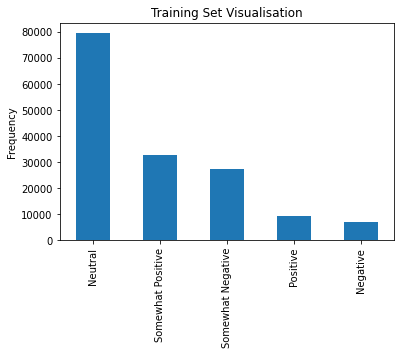

In [9]:
Frequency = train['Sentiment'].value_counts()
import matplotlib.pyplot as plt
analysis_plot = Frequency.plot(kind='bar')
analysis_plot.set_ylabel('Frequency')
analysis_plot.set_title('Training Set Visualisation')
analysis_plot.set_xticklabels( ('Neutral', 'Somewhat Positive','Somewhat Negative','Positive','Negative') )
analysis_plot



Function for cleaning the reviews, tokenize and lemmatize them.

This function will take each phrase iteratively and it will

    remove html content
    remove non-alphabetic characters
    tokenize the sentences
    lemmatize each word to its lemma

and then return the result in the list named reviews


In [10]:
def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['Phrase']):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text() #Beaut.. usually used for web crawling helps us optiize out sentences
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text) #regular expressions
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower()) #also store in lower cases
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words] #links words with similar meaning to one word.
    
        reviews.append(lemma_words)

    return(reviews)

In [11]:
#cleaned reviews for both train and test set retrieved
nltk.download('punkt')
nltk.download('wordnet')
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)
print(len(train_sentences))
print(len(test_sentences))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


100%|██████████| 66292/66292 [00:28<00:00, 2362.13it/s]

156060
66292


In [12]:
target=train.Sentiment.values
y_target=to_categorical(target) #converts into binary class matrix for futher computation
num_classes=y_target.shape[1]

In [13]:
X_train,X_val,y_train,y_val=train_test_split(train_sentences,y_target,test_size=0.2,stratify=y_target)

In [14]:
#It is needed for initializing tokenizer of keras and subsequent padding

unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)

100%|██████████| 124848/124848 [00:00<00:00, 465396.34it/s]

13734
48


In [15]:


tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train)) #creates a sort of mapping (word->index)

#texts_to_sequences(texts)

    # Arguments- texts: list of texts to turn to sequences.
    #Return: list of sequences (one per text input).
#transforms each text in texts to a sequence of integers. So it basically 
#takes each word in the text and replaces it with its corresponding integer 
#value from the word_index dictionary
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

#padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
#Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.
#basically adds an arbitrary number where a row or column doesn't have a particular length
X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

print(X_train.shape,X_val.shape,X_test.shape)



(124848, 48) (31212, 48) (66292, 48)


In [16]:


early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]



In [17]:
#Model using Keras LSTM

#Multilayer Perceptron (MLP) for multi-class softmax classification:
#Let’s build what’s probably the most popular type of model in NLP at the moment: Long Short Term Memory network. 
#This architecture is specially designed to work on sequence data.
#It fits perfectly for many NLP tasks like tagging and text classification.
#It treats the text as a sequence rather than a bag of words or as ngrams.

#Here’s a possible model definition:

model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 48, 300)           4120200   
_________________________________________________________________
lstm (LSTM)                  (None, 48, 128)           219648    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 4,396,261
Trainable params: 4,396,261
Non-trainable params: 0
______________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=6, batch_size=256, verbose=1, callbacks=callback)

Epoch 1/6
488/488 [==============================] - 527s 1s/step - loss: 1.1062 - accuracy: 0.5576 - val_loss: 0.8422 - val_accuracy: 0.6564
Epoch 2/6
488/488 [==============================] - 494s 1s/step - loss: 0.7879 - accuracy: 0.6791 - val_loss: 0.8089 - val_accuracy: 0.6632
Epoch 3/6
488/488 [==============================] - 494s 1s/step - loss: 0.7073 - accuracy: 0.7077 - val_loss: 0.8069 - val_accuracy: 0.6703
Epoch 4/6
488/488 [==============================] - 498s 1s/step - loss: 0.6669 - accuracy: 0.7225 - val_loss: 0.8281 - val_accuracy: 0.6729
Epoch 5/6
488/488 [==============================] - 489s 1s/step - loss: 0.6358 - accuracy: 0.7355 - val_loss: 0.8651 - val_accuracy: 0.6689
Epoch 6/6
488/488 [==============================] - 485s 995ms/step - loss: 0.6125 - accuracy: 0.7430 - val_loss: 0.8965 - val_accuracy: 0.6679


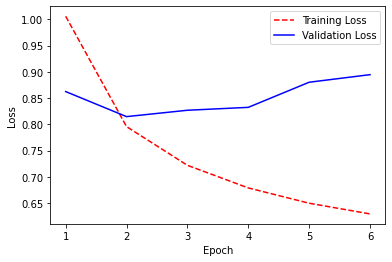

In [27]:
import matplotlib.pyplot as plt

# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [30]:
#make the predictions with trained model and submit the predictions.
y_pred=model.predict(X_test)

print(y_pred)

[[5.36594889e-04 6.79052025e-02 5.68286180e-01 3.57445598e-01
  5.82636893e-03]
 [5.36594889e-04 6.79052025e-02 5.68286180e-01 3.57445598e-01
  5.82636893e-03]
 [7.51835955e-07 2.38282303e-03 8.51327121e-01 1.46177605e-01
  1.11617155e-04]
 ...
 [2.46952157e-02 7.40175545e-01 2.29786038e-01 5.33943810e-03
  3.73152238e-06]
 [2.46952213e-02 7.40175545e-01 2.29786038e-01 5.33943530e-03
  3.73152238e-06]
 [2.95610670e-02 7.60757625e-01 2.06203654e-01 3.47551797e-03
  2.11800921e-06]]
